In [228]:
%matplotlib inline

import random
import numpy
import pylab

In [250]:


# Implements a Kalman filter.
class KalmanFilter:
  def __init__(self,_A, _B, _H, _x, _P, _Q, _R, _J):
    self.A = _A                      # State transition matrix.
    self.B = _B                      # Control matrix.
    self.H = _H                      # Observation function
    self.current_state_estimate = _x # Initial state estimate.
    self.current_prob_estimate = _P  # Initial covariance estimate.
    self.Q = _Q                      # Estimated error in process.
    self.R = _R                      # Estimated error in measurements.
    self.J = _J                      # Function to get the Jacobian of the estimation function
  def GetCurrentState(self):
    return self.current_state_estimate
  def GetCurrentProb(self):
    return self.current_prob_estimate

  def Step(self,control_vector,measurement_vector):
    #---------------------------Prediction step-----------------------------
    predicted_state_estimate = self.A * self.current_state_estimate + self.B * control_vector    
    predicted_prob_estimate = (self.A * self.current_prob_estimate) * numpy.transpose(self.A) + self.Q
    #--------------------------Observation step-----------------------------
    innovation = measurement_vector - self.H(predicted_state_estimate)
    Jacobian = self.J(predicted_state_estimate)
    #innovation_covariance = Jacobian*predicted_prob_estimate*numpy.transpose(Jacobian) + self.R
    innovation_covariance = Jacobian*predicted_prob_estimate*numpy.transpose(Jacobian) + self.R
    
    #-----------------------------Update step-------------------------------
    #kalman_gain = predicted_prob_estimate * numpy.transpose(self.H) * numpy.linalg.inv(innovation_covariance)
    #print "MM ==> ", predicted_prob_estimate
    #print "MM ==> ", numpy.transpose(Jacobian)
    #print "MM ==> ", numpy.linalg.inv(innovation_covariance)
    #print "====", predicted_prob_estimate * numpy.transpose(Jacobian)
    kalman_gain = predicted_prob_estimate * numpy.transpose(Jacobian) * numpy.linalg.inv(innovation_covariance)
    
    self.current_state_estimate = predicted_state_estimate + kalman_gain * innovation
    # We need the size of the matrix so we can make an identity matrix.
    size = self.current_prob_estimate.shape[0]
    # eye(n) = nxn identity matrix.
    self.current_prob_estimate = (numpy.eye(size)-kalman_gain*Jacobian)*predicted_prob_estimate



In [251]:
class Voltmeter:
  def __init__(self,_truevoltage,_noiselevel, _deltaT, _w):
    self.truevoltage = _truevoltage
    self.w = _w
    #self.p = 2.0
    self.noiselevel = _noiselevel
    self.deltaT = _deltaT
    self.nbSteps = 0.0
  def GetVoltage(self):
    v =  self.truevoltage * numpy.cos(self.w * self.nbSteps * self.deltaT)# + self.p)
    return v
  def step(self):
        self.nbSteps += 1.0
  def GetVoltageWithNoise(self):
    return random.gauss(self.GetVoltage(),self.noiselevel)



In [296]:


numsteps = 2000
deltaT = 0.2
Amplitude = 3.0
w = 0.15
t = numpy.arange(0, numsteps * deltaT, deltaT)
voltmeter = Voltmeter(Amplitude, 1.0, deltaT, w)

A = numpy.matrix([[1, deltaT, 0],[0, 1, 0], [0, 0, 1]])
H = lambda x: x[2,0] * numpy.cos(x[0,0])
J = lambda x: numpy.matrix([- x[2,0] * numpy.sin(x[0,0]), 
                                                0, 
                                           numpy.cos(x[0,0])])
B = numpy.zeros((3, 3))
Q = 0.00001 * numpy.eye(3, 3)
R = numpy.matrix([0.1])
xhat = numpy.transpose(numpy.matrix([0, 1, 1]))
P    = numpy.ones((3, 3))

filter = KalmanFilter(A,B,H,xhat,P,Q,R, J)

measuredvoltage = []
truevoltage = []
kalman = []
Aest = []
Aest_un = []
west = []
west_un = []

for i in range(numsteps):
    measured = voltmeter.GetVoltageWithNoise()
    measuredvoltage.append(measured)
    truevoltage.append(voltmeter.GetVoltage())
    kalman.append(H(filter.GetCurrentState()))
    curState = filter.GetCurrentState()
    curProb = filter.GetCurrentProb()
    Aest.append(curState[2,0])
    Aest_un.append(numpy.sqrt(curProb[2,2]))
    west.append(curState[1,0])
    west_un.append(numpy.sqrt(curProb[1,1]))

                   #print filter.GetCurrentState()[2,0]
    filter.Step(numpy.transpose(numpy.matrix([0, 0, 0])),
                                numpy.matrix([measured]))
    voltmeter.step()


print "A= %f +/- %f" % (filter.GetCurrentState()[2, 0], numpy.sqrt(filter.GetCurrentProb()[2, 2]))
print "w= %f +/- %f" % (filter.GetCurrentState()[1, 0], numpy.sqrt(filter.GetCurrentProb()[1, 1]))



A= 3.023036 +/- 0.042985
w= -0.118659 +/- 0.020167


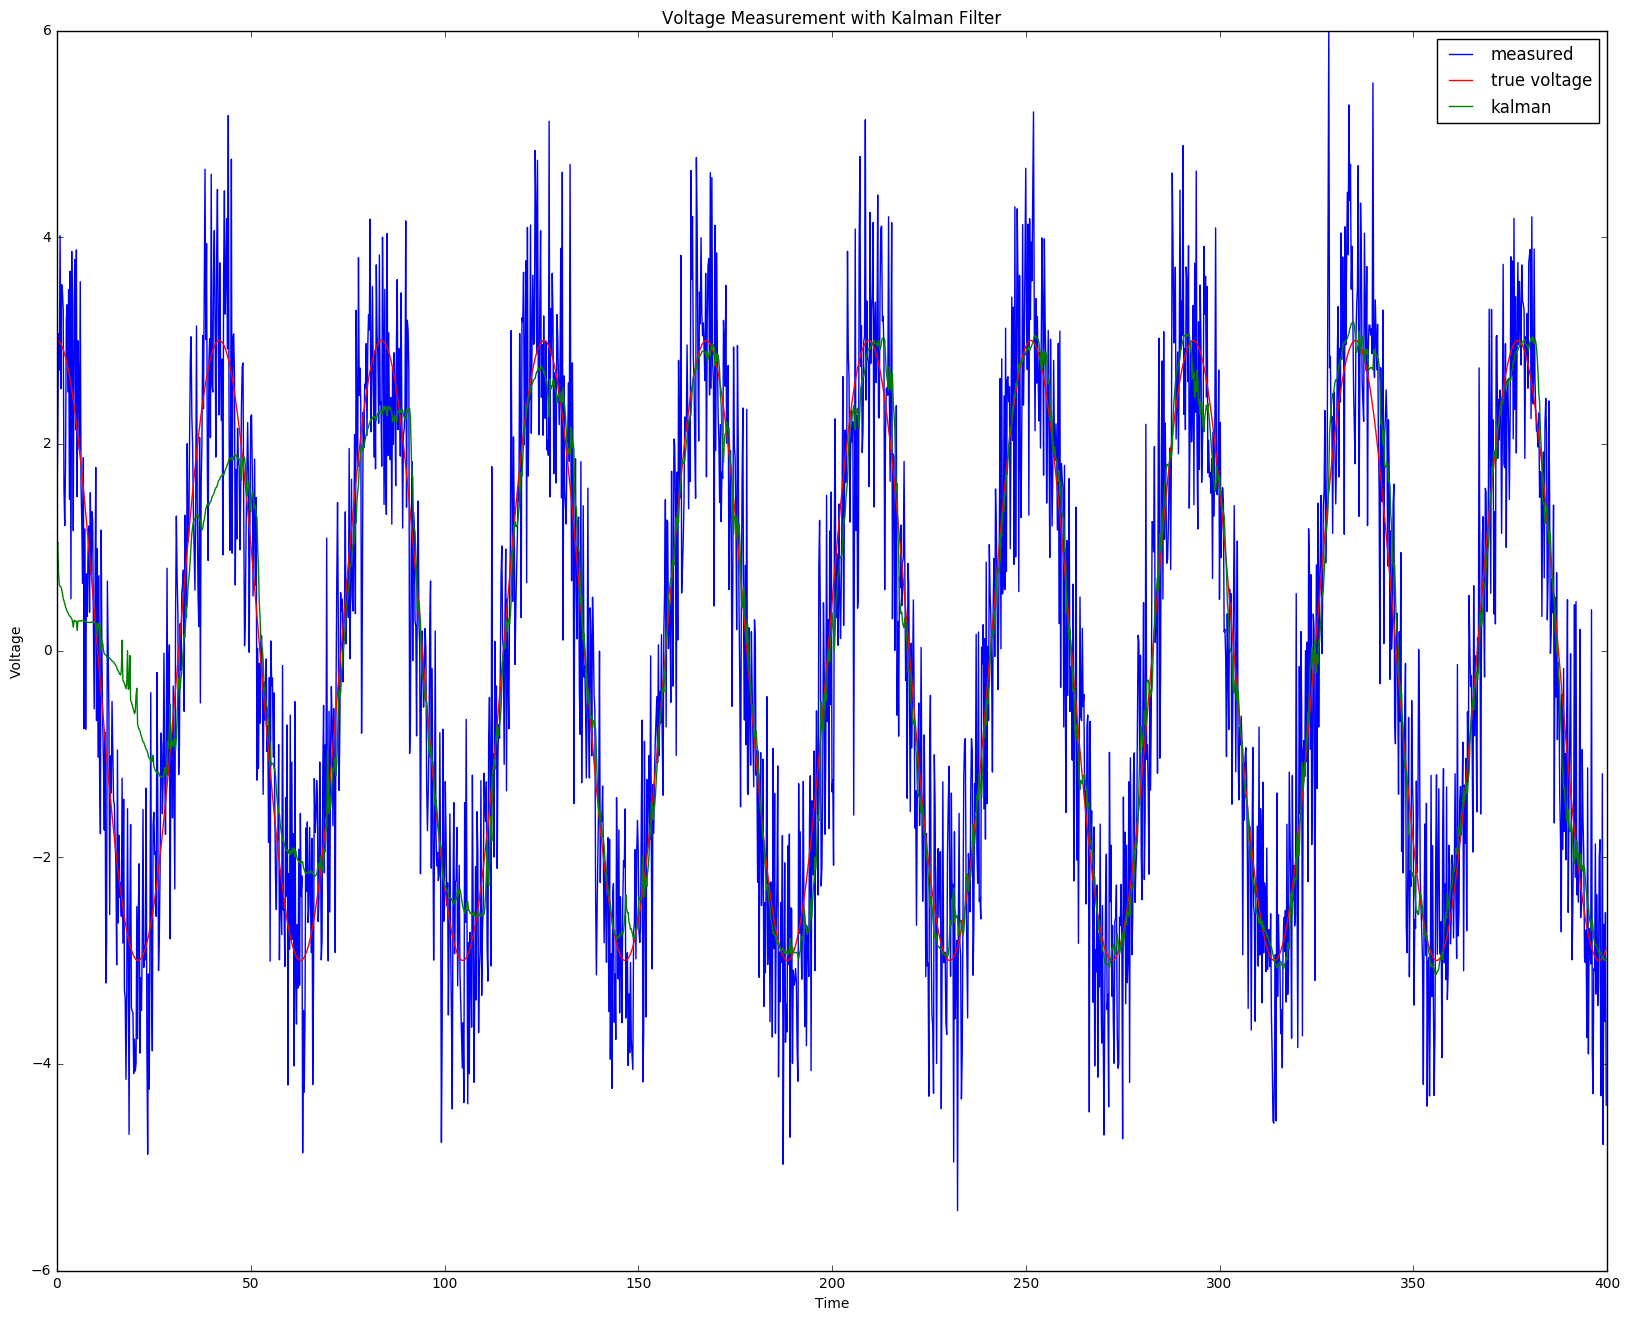

In [297]:
pylab.rcParams['figure.figsize'] = (20.0, 16.0)
pylab.plot(t,measuredvoltage,'b',t,truevoltage,'r',t,kalman,'g')
pylab.xlabel('Time')
pylab.ylabel('Voltage')
pylab.title('Voltage Measurement with Kalman Filter')
pylab.legend(('measured','true voltage','kalman'))
pylab.show()


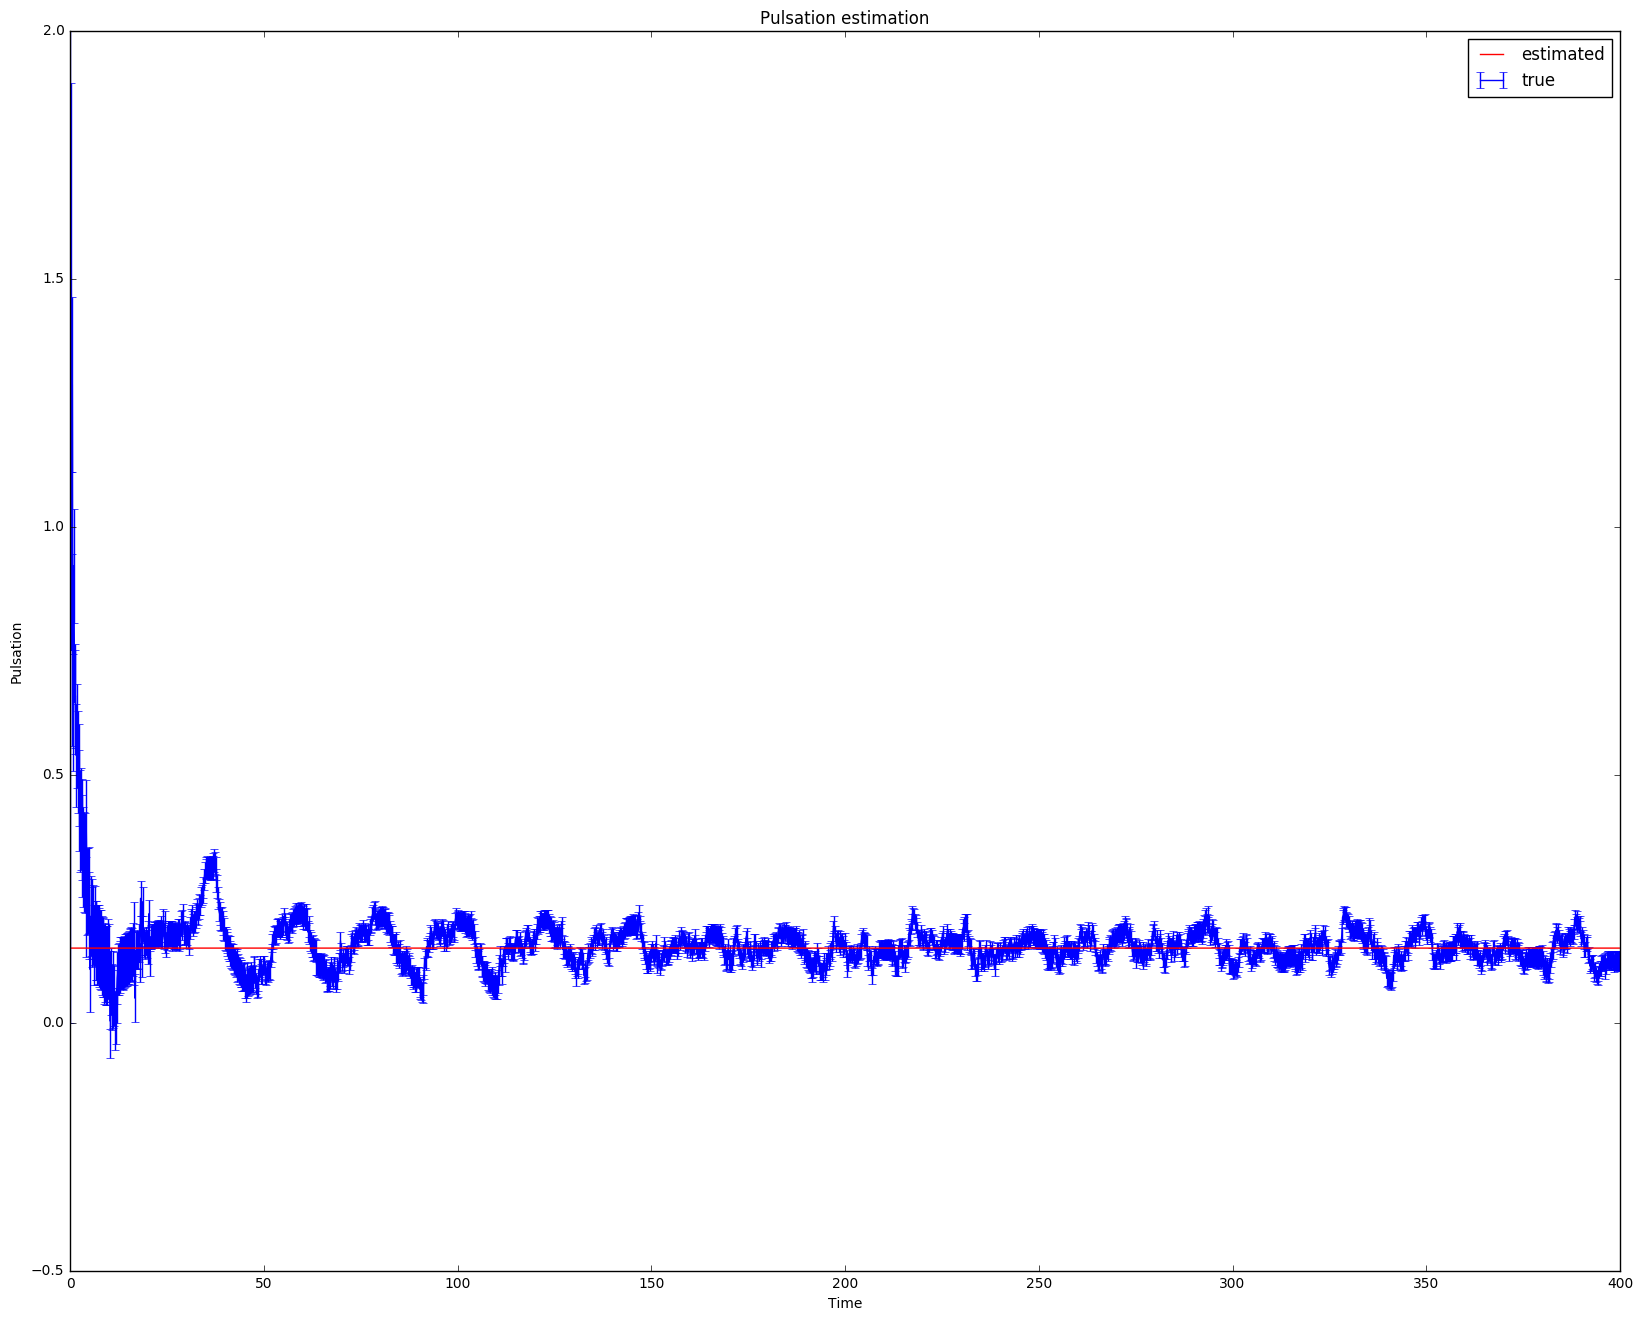

In [298]:
pylab.rcParams['figure.figsize'] = (20.0, 16.0)
pylab.errorbar(t,numpy.abs(west), yerr=west_un)
pylab.plot(t, [w] * t.size, 'r')
pylab.xlabel('Time')
pylab.ylabel('Pulsation')
pylab.title('Pulsation estimation')
pylab.legend(('estimated','true'))
pylab.show()

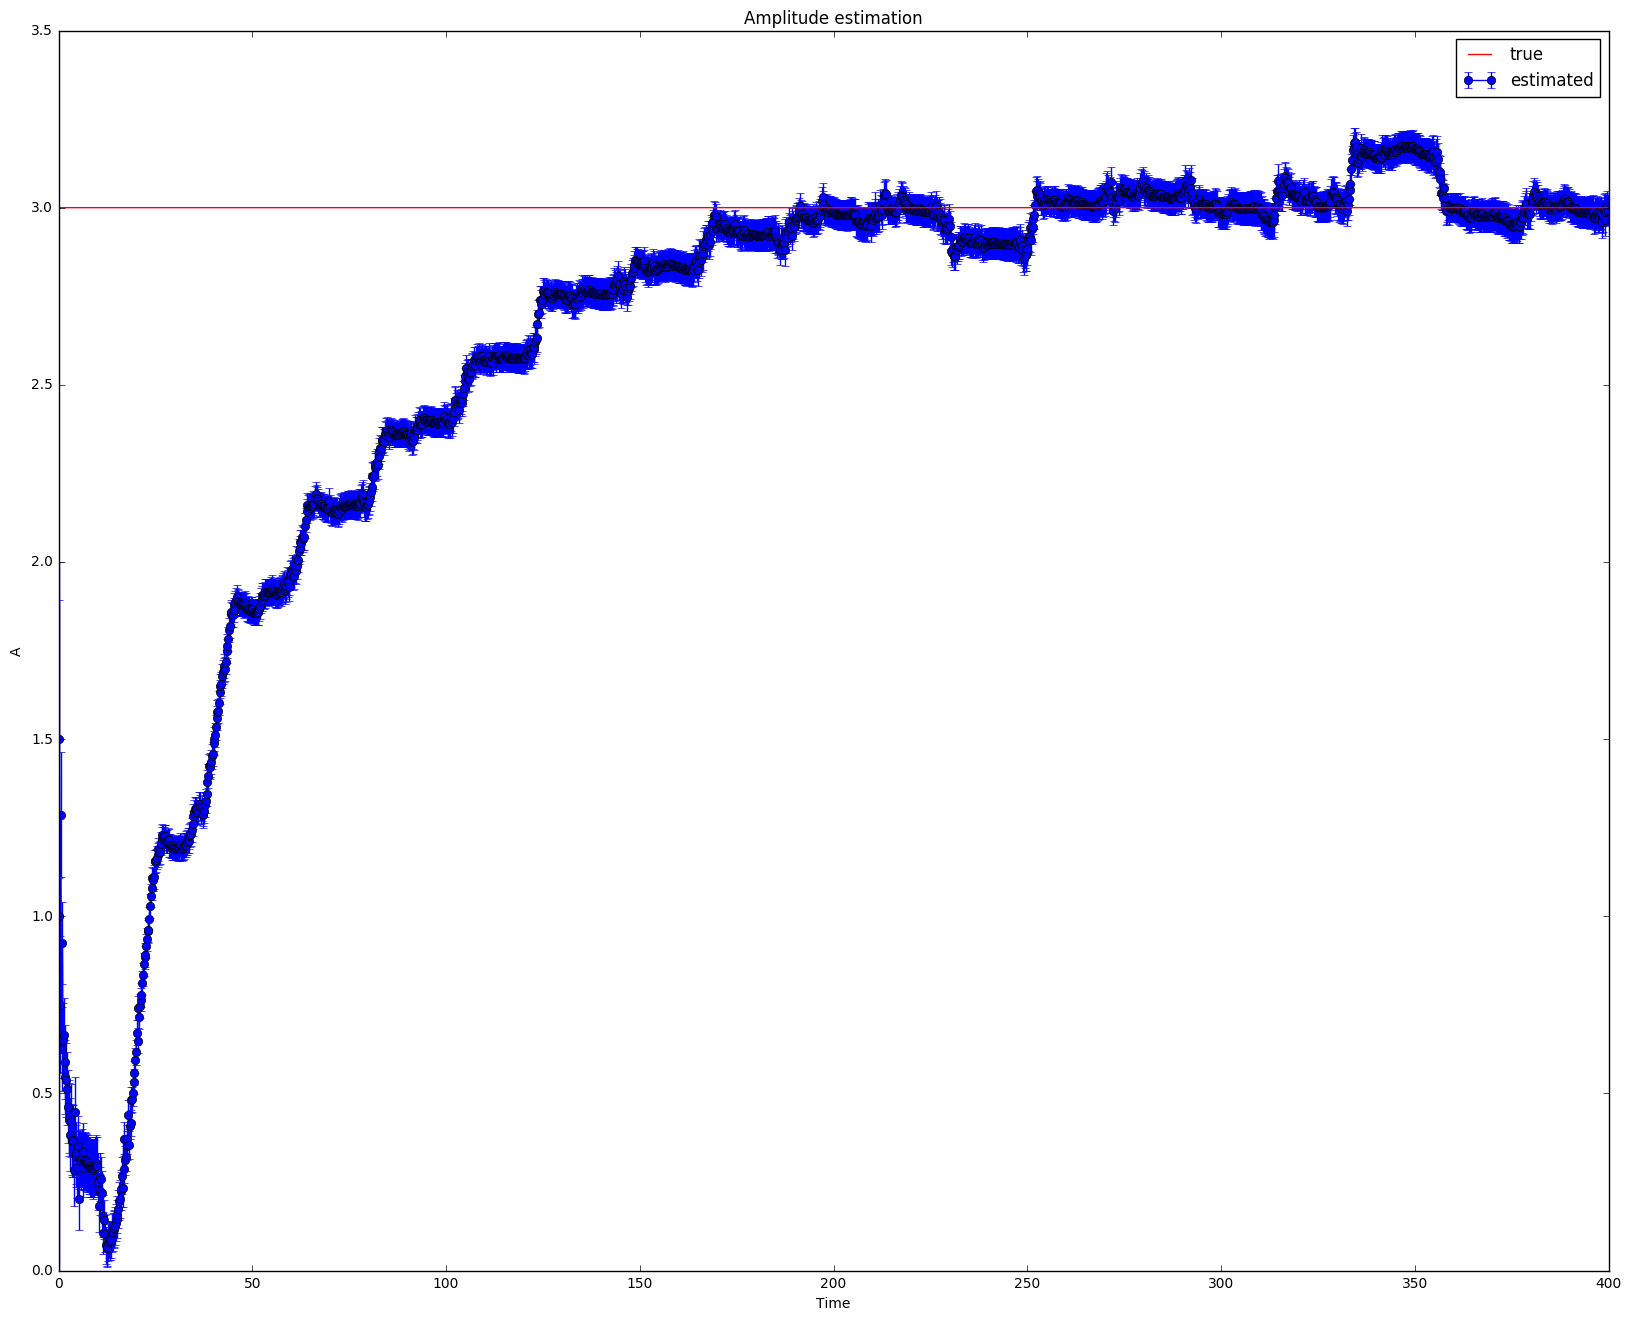

In [299]:
pylab.rcParams['figure.figsize'] = (20.0, 16.0)
pylab.errorbar(t,Aest, yerr=Aest_un, fmt='-o')
pylab.plot(t, [Amplitude] * t.size, 'r')
pylab.xlabel('Time')
pylab.ylabel('A')
pylab.title('Amplitude estimation')
pylab.legend(('true', 'estimated'))
pylab.show()